In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import re
import time
from BusinessHours import BusinessHours as bh
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Imputer
from sklearn.metrics import make_scorer 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import metrics

In [109]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv('train_aWnotuB.csv', parse_dates=['DateTime'], index_col='DateTime', infer_datetime_format=True)
df_test = pd.read_csv('test_BdBKkAj.csv', parse_dates=['DateTime'], index_col='DateTime', infer_datetime_format=True)

In [110]:
df.head()
#df.describe()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


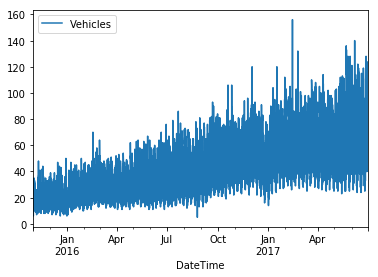

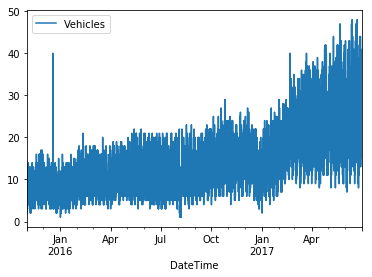

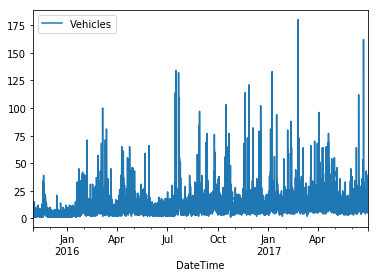

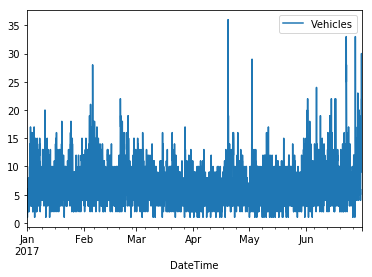

In [91]:
for i in range(1,5):
    df[df['Junction']==i][['Vehicles']].plot()

In [111]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):  
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:,0].values
    series = pd.Series(series)

    rolmean = series.rolling(window=12).mean() #pd.rolling_mean(series, window=12)
    rolstd = series.rolling(window=12).std()

    plt.plot(series, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.title('Rolling Mean & SD')
    plt.legend(loc='best')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','#Num Data'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

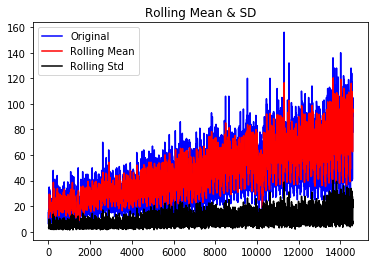

Results of Dickey-Fuller Test:
Test Statistic         -7.148078e+00
p-value                 3.193843e-10
#Lags Used              4.200000e+01
#Num Data               1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


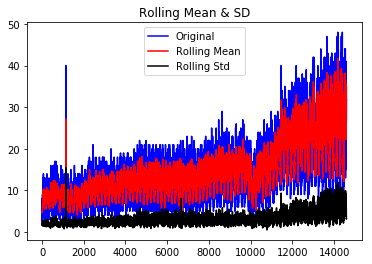

Results of Dickey-Fuller Test:
Test Statistic         -8.041077e+00
p-value                 1.846368e-12
#Lags Used              4.200000e+01
#Num Data               1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


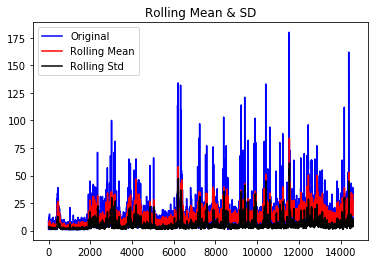

Results of Dickey-Fuller Test:
Test Statistic         -8.236600e+00
p-value                 5.867296e-13
#Lags Used              4.200000e+01
#Num Data               1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


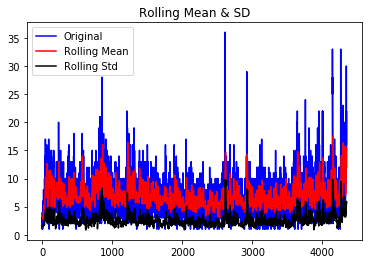

Results of Dickey-Fuller Test:
Test Statistic         -6.726732e+00
p-value                 3.374875e-09
#Lags Used              3.000000e+01
#Num Data               4.313000e+03
Critical Value (1%)    -3.431867e+00
Critical Value (5%)    -2.862210e+00
Critical Value (10%)   -2.567127e+00
dtype: float64


In [93]:
for i in range(1,5):
    test_stationarity(df[df['Junction']==i][['Vehicles']])

In [112]:
df['vl'] = df.groupby('Junction')['Vehicles'].apply(lambda df: np.log(df))

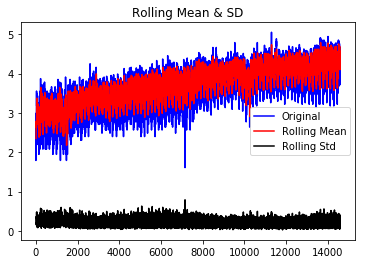

Results of Dickey-Fuller Test:
Test Statistic         -6.305408e+00
p-value                 3.332993e-08
#Lags Used              4.200000e+01
#Num Data               1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


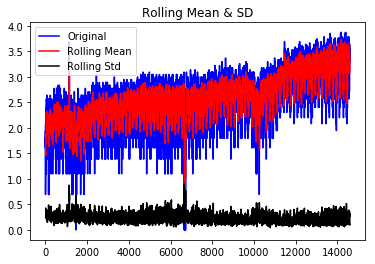

Results of Dickey-Fuller Test:
Test Statistic         -8.459969e+00
p-value                 1.576998e-13
#Lags Used              4.200000e+01
#Num Data               1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


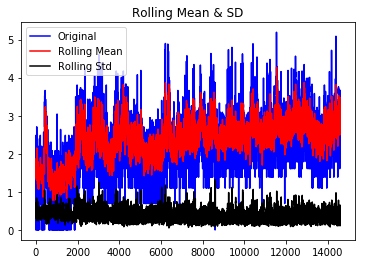

Results of Dickey-Fuller Test:
Test Statistic         -5.740527e+00
p-value                 6.291014e-07
#Lags Used              4.200000e+01
#Num Data               1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


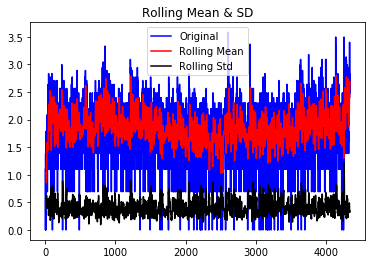

Results of Dickey-Fuller Test:
Test Statistic         -7.190868e+00
p-value                 2.505757e-10
#Lags Used              3.100000e+01
#Num Data               4.312000e+03
Critical Value (1%)    -3.431867e+00
Critical Value (5%)    -2.862211e+00
Critical Value (10%)   -2.567127e+00
dtype: float64


In [95]:
for i in range(1,5):
    test_stationarity(df[df['Junction']==i][['vl']])

In [96]:
from pandas.stats.moments import ewma
df['expwighted_avg'] = df.groupby('Junction')['vl'].apply(lambda df: pd.ewma(df, 12))

/home/smrutiranjans/miniconda3/envs/ai/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=12,min_periods=0,adjust=True,ignore_na=False).mean()
  


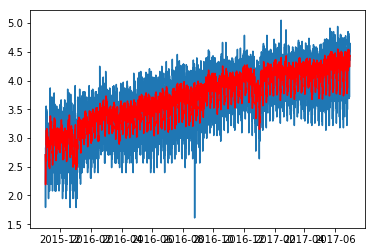

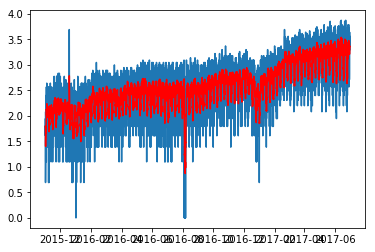

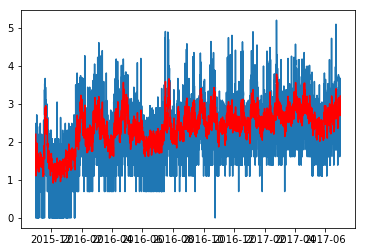

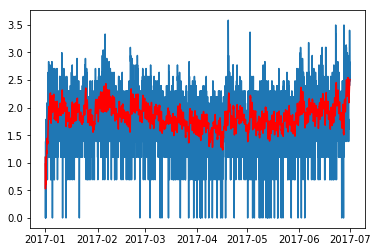

In [97]:
for i in range(1,5):
    plt.plot(df[df['Junction']==i][['vl']])
    plt.plot(df[df['Junction']==i][['expwighted_avg']], color='red')
    plt.show(block=False)

### Exponential weighted avg

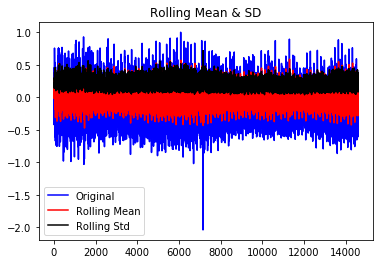

Results of Dickey-Fuller Test:
Test Statistic            -20.351310
p-value                     0.000000
#Lags Used                 42.000000
#Num Data               14549.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


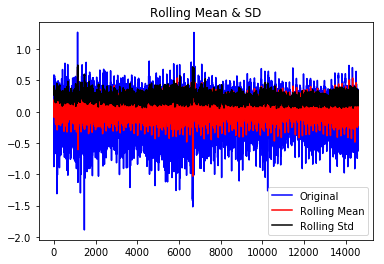

Results of Dickey-Fuller Test:
Test Statistic            -21.119334
p-value                     0.000000
#Lags Used                 41.000000
#Num Data               14550.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


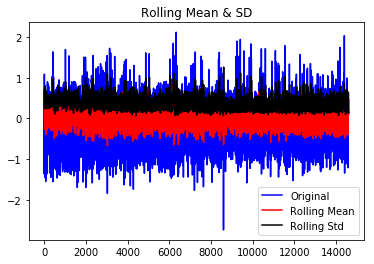

Results of Dickey-Fuller Test:
Test Statistic            -21.748046
p-value                     0.000000
#Lags Used                 42.000000
#Num Data               14549.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


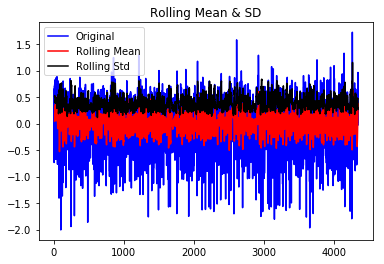

Results of Dickey-Fuller Test:
Test Statistic         -1.305590e+01
p-value                 2.095289e-24
#Lags Used              3.100000e+01
#Num Data               4.312000e+03
Critical Value (1%)    -3.431867e+00
Critical Value (5%)    -2.862211e+00
Critical Value (10%)   -2.567127e+00
dtype: float64


In [98]:
# df['log_ewma_diff'] = df['vl'] - df['expwighted_avg']
# #ts_log_ewma_diff.dropna(inplace=True)
# for i in range(1,5):
#     test_stationarity(df[df['Junction']==i][['log_ewma_diff']])

## Trend & Seasonality

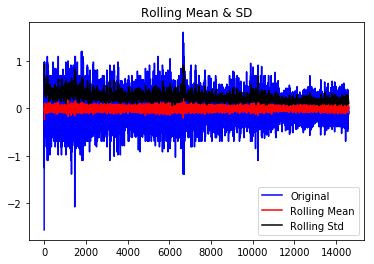

Results of Dickey-Fuller Test:
Test Statistic            -20.509961
p-value                     0.000000
#Lags Used                 42.000000
#Num Data               14549.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


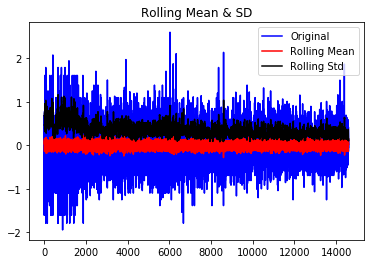

Results of Dickey-Fuller Test:
Test Statistic            -26.481438
p-value                     0.000000
#Lags Used                 42.000000
#Num Data               14549.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


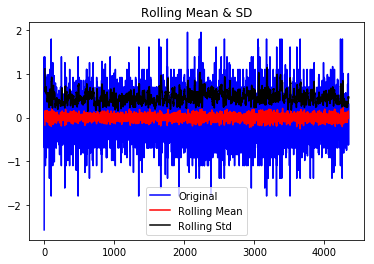

Results of Dickey-Fuller Test:
Test Statistic         -1.672002e+01
p-value                 1.411113e-29
#Lags Used              3.000000e+01
#Num Data               4.313000e+03
Critical Value (1%)    -3.431867e+00
Critical Value (5%)    -2.862210e+00
Critical Value (10%)   -2.567127e+00
dtype: float64


In [99]:
df['log_diff'] = df['vl'] - df['vl'].shift()
df['log_diff'].dropna(inplace=True)
for i in range(2,5):
    test_stationarity(df[df['Junction']==i][['log_diff']])

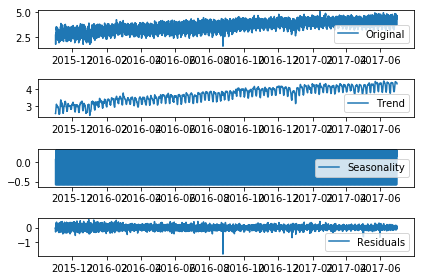

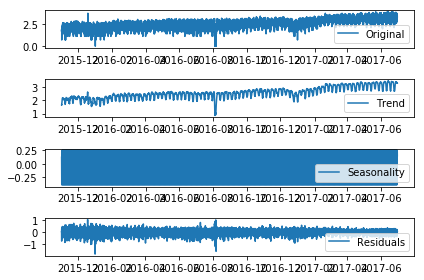

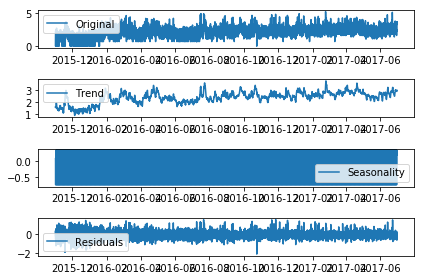

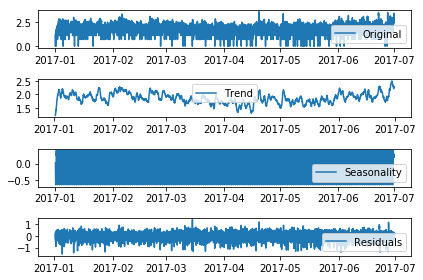

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
df['decomposition'] = df.groupby('Junction')['vl'].apply(lambda df: seasonal_decompose(df))
df['trend'] = df.groupby('Junction')['vl'].apply(lambda df: seasonal_decompose(df).trend)
df['seasonal'] = df.groupby('Junction')['vl'].apply(lambda df: seasonal_decompose(df).seasonal)
df['resid'] = df.groupby('Junction')['vl'].apply(lambda df: seasonal_decompose(df).resid)

for i in range(1,5):
    ts_log = df[df['Junction']==i]['vl'] 
    trend = df[df['Junction']==i][['trend']]
    seasonal = df[df['Junction']==i]['seasonal']
    residual = df[df['Junction']==i]['resid']

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show(block=False)

/home/smrutiranjans/miniconda3/envs/ai/lib/python3.6/site-packages/pandas/core/series.py:2726: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


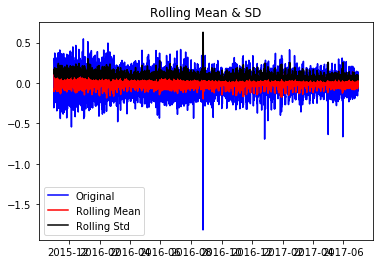

Results of Dickey-Fuller Test:
Test Statistic            -25.949691
p-value                     0.000000
#Lags Used                 42.000000
#Num Data               14525.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


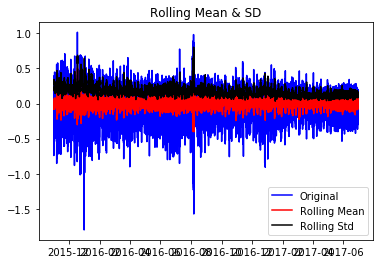

Results of Dickey-Fuller Test:
Test Statistic            -28.307305
p-value                     0.000000
#Lags Used                 38.000000
#Num Data               14529.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


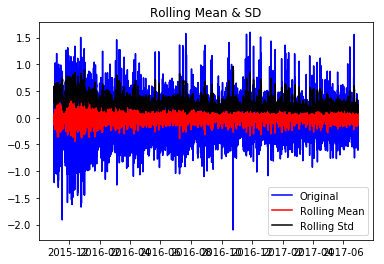

Results of Dickey-Fuller Test:
Test Statistic            -34.916196
p-value                     0.000000
#Lags Used                 42.000000
#Num Data               14525.000000
Critical Value (1%)        -3.430800
Critical Value (5%)        -2.861739
Critical Value (10%)       -2.566876
dtype: float64


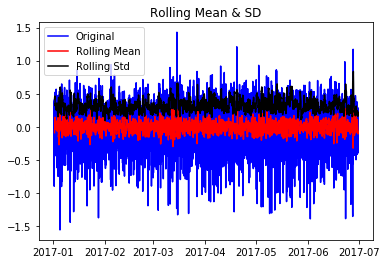

Results of Dickey-Fuller Test:
Test Statistic           -20.574557
p-value                    0.000000
#Lags Used                31.000000
#Num Data               4288.000000
Critical Value (1%)       -3.431876
Critical Value (5%)       -2.862214
Critical Value (10%)      -2.567129
dtype: float64


In [101]:
for i in range(1,5):
    residual = df[df['Junction']==i]['resid']
    ts_log_decompose = residual
    ts_log_decompose.dropna(inplace=True)
    test_stationarity(ts_log_decompose)

In [102]:
from statsmodels.tsa.arima_model import ARIMA

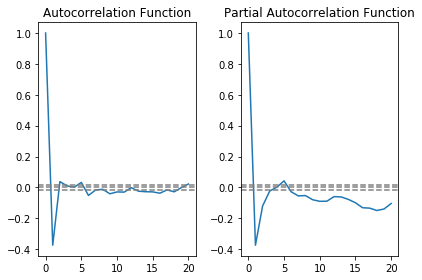

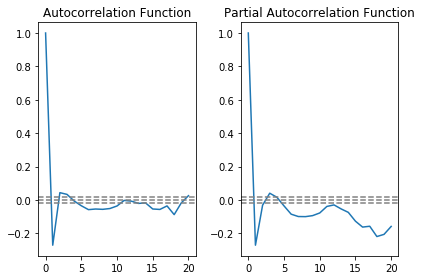

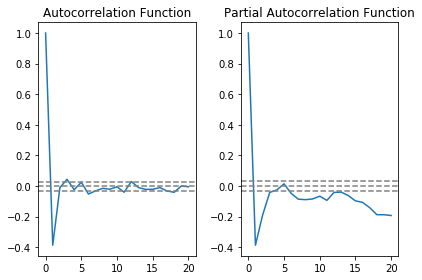

In [103]:
from statsmodels.tsa.stattools import acf, pacf  

for i in range(2,5):
    ts_log_diff = df[df['Junction']==i][['log_diff']]

    lag_acf = acf(ts_log_diff, nlags=20)
    lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

    #Plot ACF:    
    plt.subplot(121)    
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show(block=False)

In [1]:
models = []
for i in range(1,5):
    #ts_log_diff = df[df['Junction']==i][['log_diff']]
    ts_log = df[df['Junction']==i][['vl']]
    model = ARIMA(ts_log, order=(2, 1, 2)).fit(disp=-1)
    models.append(model)
    #plt.plot(ts_log_diff)
    plt.plot(model.fittedvalues, color='red')
    #plt.title('RSS: %.4f'% np.sum((np.array(model.fittedvalues.values)-np.array(ts_log_diff.values))**2))
    plt.show(block=False)

NameError: name 'df' is not defined

In [105]:
#ARIMA(df['vl'], order=(2, 1, 2)).fit(disp=-1)

In [115]:
start_index = '2017-07-01 00:00:00'
end_index = '2017-10-31 00:00:00'
pred = pd.Series()
for model in models:
    pred = pred.append(np.exp(model.predict(start=start_index, end=end_index)).round().astype('int'))

In [116]:
pred

2017-07-01 00:00:00    1
2017-07-01 01:00:00    1
2017-07-01 02:00:00    1
2017-07-01 03:00:00    1
2017-07-01 04:00:00    1
2017-07-01 05:00:00    1
2017-07-01 06:00:00    1
2017-07-01 07:00:00    1
2017-07-01 08:00:00    1
2017-07-01 09:00:00    1
2017-07-01 10:00:00    1
2017-07-01 11:00:00    1
2017-07-01 12:00:00    1
2017-07-01 13:00:00    1
2017-07-01 14:00:00    1
2017-07-01 15:00:00    1
2017-07-01 16:00:00    1
2017-07-01 17:00:00    1
2017-07-01 18:00:00    1
2017-07-01 19:00:00    1
2017-07-01 20:00:00    1
2017-07-01 21:00:00    1
2017-07-01 22:00:00    1
2017-07-01 23:00:00    1
2017-07-02 00:00:00    1
2017-07-02 01:00:00    1
2017-07-02 02:00:00    1
2017-07-02 03:00:00    1
2017-07-02 04:00:00    1
2017-07-02 05:00:00    1
                      ..
2017-10-29 19:00:00    1
2017-10-29 20:00:00    1
2017-10-29 21:00:00    1
2017-10-29 22:00:00    1
2017-10-29 23:00:00    1
2017-10-30 00:00:00    1
2017-10-30 01:00:00    1
2017-10-30 02:00:00    1
2017-10-30 03:00:00    1
